## 필요 라이브러리 설치
- einops: 텐서 차원 조작을 도와주는 라이브러리




In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00


# 필요 라이브러리 import


In [34]:
import time
import urllib.request
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.layers import (
    Layer,
    LayerNormalization,
    Dropout,
    Embedding,
    Softmax
)
from tensorflow.keras.models import Model, Sequential

from einops import rearrange, pack, unpack, einsum
from einops.layers.tensorflow import EinMix

# 챗봇 데이터 로드
- 출처: https://github.com/songys/Chatbot_data
  - 챗봇 트레이닝용 문답 페어 11,876개
  - 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
train_data['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

# 전처리 함수 구현

In [8]:
def preprocess_sentence(sentence):
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()

    return sentence

In [6]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = pad_sequences(
      tokenized_inputs,
      maxlen=MAX_LENGTH,
      padding='post'
  )
  tokenized_outputs = pad_sequences(
      tokenized_outputs,
      maxlen=MAX_LENGTH,
      padding='post'
  )

  return tokenized_inputs, tokenized_outputs

# 전처리 수행


## 질의응답 문장 전처리(1)
- 구두점 제거

In [9]:
questions = [preprocess_sentence(sentence) for sentence in train_data['Q']]
answers = [preprocess_sentence(sentence) for sentence in train_data['A']]

In [10]:
questions[:5]

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']

In [11]:
answers[:5]

['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']

## 단어집합 생성

In [12]:
# SubwordTextEncoder를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 2만큼 증가
VOCAB_SIZE = tokenizer.vocab_size + 2

In [13]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [14]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [15]:
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[10]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5779, 484, 194, 2984, 45, 3818]
기존 문장: SNS보면 나만 빼고 다 행복해보여


In [16]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# SubwordTextEncoder는 의미있는 단위의 서브워드로 토크나이징한다.
# 띄어쓰기 단위 X,  형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5779 ----> SNS
484 ----> 보면 
194 ----> 나만 
2984 ----> 빼고 
45 ----> 다 
3818 ----> 행복해보여


## 질의응답 문장 전처리(2)
- 토큰화
- 정수 인코딩
- 문장 시작 및 종료 토큰 추가
- 패딩

In [17]:
questions, answers = tokenize_and_filter(questions, answers)

In [18]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [19]:
# 7번째 샘플을 임의로 출력
print(questions[6])
print(answers[6])

[8178 8005 7990 2192  199 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178   69 2064  456    5  137 2188   17    1 8179    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [20]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


## 데이터셋 생성
- 올바른 번역 학습을 위하여 Teacher forcing 방법을 사용
- 따라서, 라벨을 따로 분리하여 저장

In [21]:
# Tensorflow dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한, 이 과정에서 Teacher forcing을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1], # 디코더의 입력. 마지막 패딩 토큰이 제거된다.,
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    }
))

dataset = dataset.cache()    # 같은 데이터를 여러번 가져올 경우, 시간 감축을 위하여 캐싱 사용
dataset = dataset.shuffle(BUFFER_SIZE)   # 데이터 셔플링
dataset = dataset.batch(BATCH_SIZE)      # 배치 사이즈만큼, 데이터 적재
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)   # 모델 학습 시, 백그라운드 스레드를 이용하여 다음 step에 사용할 데이터 미리 적재

In [22]:
for data in dataset:
    print(data)
    break

{'inputs': <tf.Tensor: shape=(64, 40), dtype=int32, numpy=
array([[8178,   84, 3381, ...,    0,    0,    0],
       [8178,  949,  441, ...,    0,    0,    0],
       [8178,   57, 1861, ...,    0,    0,    0],
       ...,
       [8178, 1895, 7340, ...,    0,    0,    0],
       [8178,  148,  286, ...,    0,    0,    0],
       [8178,   57, 1439, ...,    0,    0,    0]], dtype=int32)>, 'dec_inputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[8178, 6506, 2431, ...,    0,    0,    0],
       [8178,  228, 6270, ...,    0,    0,    0],
       [8178, 3502,   14, ...,    0,    0,    0],
       ...,
       [8178, 5684,    5, ...,    0,    0,    0],
       [8178,  161,   20, ...,    0,    0,    0],
       [8178, 4383,   10, ...,    0,    0,    0]], dtype=int32)>, 'outputs': <tf.Tensor: shape=(64, 39), dtype=int32, numpy=
array([[6506, 2431, 6569, ...,    0,    0,    0],
       [ 228, 6270,  306, ...,    0,    0,    0],
       [3502,   14, 1045, ...,    0,    0,    0],
       ...,
  

# Transformer 구현
- Positional Encoding
- Multi-Head attention
- Encoder layer
- Encoder
- Decoder layer
- Decoder
- Transformer

## Positional Encoding

In [23]:
class PositionalEncoding(Layer):
  def __init__(
      self,
      position: int,
      embed_dim: int
  ):
      super(PositionalEncoding, self).__init__()
      self.pos_encoding = self.positional_encoding(position, embed_dim)

  def get_angles(
      self,
      position,
      idx,
      embed_dim: int
    ) -> EagerTensor:
      angles = 1 / tf.pow(10000, (2 * (idx // 2)) / tf.cast(embed_dim, tf.float32))
      return position * angles

  def positional_encoding(
      self,
      position: int,
      embed_dim: int
    ) -> EagerTensor:
      angle_rads = self.get_angles(
          position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
          idx=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
          embed_dim=embed_dim
      )  # (sequence_len, embed_dim)

      # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
      sines = tf.math.sin(angle_rads[:, 0::2])

      # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
      cosines = tf.math.cos(angle_rads[:, 1::2])

      angle_rads = np.zeros(angle_rads.shape)
      angle_rads[:, 0::2] = sines
      angle_rads[:, 1::2] = cosines
      pos_encoding = tf.constant(angle_rads)   # (sequence_len, embed_dim)
      pos_encoding = pos_encoding[tf.newaxis, ...]  # (1, sequence_len, embed_dim)

      return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
      return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]   # (batch_size, sequence_len, embed_dim)

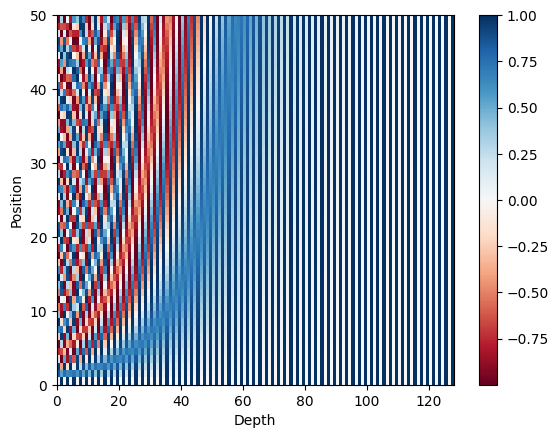

In [24]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [25]:
type(sample_pos_encoding.pos_encoding)

tensorflow.python.framework.ops.EagerTensor

## Multi-head attention

In [26]:
# 패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것입니다.
# 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.
def create_padding_mask(tensor):
    '''
    tensor: (batch_size, sequence_len)
    '''
    mask = tf.cast(tf.math.equal(tensor, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, key의 문장 길이)

In [27]:
class MultiHeadAttentionLayer(Layer):
  def __init__(
      self,
      embed_dim: int = 512,   # 임베딩 차원
      head_num: int = 8,      # 헤드 갯수
      name="multi_head_attention"
  ):
    super(MultiHeadAttentionLayer, self).__init__(name=name)
    self.head_num = head_num
    self.embed_dim = embed_dim

    assert self.embed_dim % self.head_num == 0

    self.mh_dim = self.embed_dim // self.num_heads  # 멀티 헤드 어텐션 내 임베딩 차원

    # Dense layer와 기능이 같지만, tensor 입출력 구조를 손쉽게 확인 가능함
    self.to_query = EinMix(
      pattern='batch sequence dim_in -> batch sequence dim_out',
      weight_shape='dim_in dim_out',
      bias_shape='dim_out',
      dim_in=embed_dim,
      dim_out=embed_dim
    )

    self.to_key = EinMix(
      pattern='batch sequence dim_in -> batch sequence dim_out',
      weight_shape='dim_in dim_out',
      bias_shape='dim_out',
      dim_in=embed_dim,
      dim_out=embed_dim
    )

    self.to_value = EinMix(
      pattern='batch sequence dim_in -> batch sequence dim_out',
      weight_shape='dim_in dim_out',
      bias_shape='dim_out',
      dim_in=embed_dim,
      dim_out=embed_dim
    )

    # 멀티 헤드 어텐션 출력층에 대응하는 레이어
    self.dense = EinMix(
        pattern='batch sequence dim_in -> batch sequence dim_out',
        weight_shape='dim_in dim_out',
        bias_shape='dim_out',
        dim_in=embed_dim,
        dim_out=embed_dim
    )

  def call(
      self,
      query,
      key,
      value,
      mask
    ):
    '''
    query, key, value: (batch_size, sequence_len, embed_dim)
    mask: (batch_size, 1, 1, sequence_len)
    '''
    # 1. query, key, value 텐서 얻기
    query = self.to_query(query)
    key = self.to_key(key)
    value = self.to_value(value)

    # 2. query, key, value에 대해 멀티 헤드 텐서로 변경
    query, key, value = map(
        lambda x: rearrange(tensor=x, pattern='b s (h d) -> b h s d', h=self.head_num),
        (query, key, value)
    )  # (batch_size, multi-head_num, sequence_len, multi-head_embed_dim)

    # 3. dot product (query-key)
    energy = einsum(
        query,
        value,
        pattern='b h q d, b h k d -> b h q k'
    )  # (batch_size, multi-head_num, sequence_len, sequence_len)

    # 4. scaled dot product
    scaled_energy = energy * self.mh_dim**-0.5   # (batch_size, multi-head_num, sequence_len, sequence_len)
    if mask is not None:  # mask는 패딩 마스크 또는 look-ahead 마스크 둘 중 하나
        scaled_energy += (mask * -1e9)

    # 5. attention score 계산
    attention_score = tf.nn.softmax(scaled_energy, axis=-1)  # (batch size, number of multi-head, sequence_len, sequence_len)

    # 6. attention vector 계산
    outputs = einsum(
        attention_score,
        value,
        pattern='b h q k, b h k d -> b h q d'
    )  # (batch size, number of multi-head, sequence length, multi-head embed_dim)
    outputs = rearrange(
        outputs,
        pattern='b h q d -> b q (h d)'
    )  # (batch size, sequence length, embed_dim)

    # 7. Dense layer 통과 (for Residual connection)
    outputs = self.dense(outputs)


    return outputs  # (batch size, sequence length, embed_dim)

## Feed-forward

In [28]:
class FeedForwardLayer(Layer):
    def __init__(
        self,
        hidden_dim: int,
        embed_dim: int,
        name: str = 'FeedForward'
    ):
        super(FeedForwardLayer, self).__init__(name=name)
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        self.dense_1 = EinMix(
            pattern="batch sequence dim_in -> batch sequence dim_out",
            weight_shape="dim_in dim_out",
            bias_shape="dim_out",
            dim_in=embed_dim,
            dim_out=hidden_dim
        )
        self.dense_2 = EinMix(
            pattern="batch sequence dim_out -> batch sequence dim_in",
            weight_shape="dim_out dim_in",
            bias_shape="dim_in",
            dim_in=embed_dim,
            dim_out=hidden_dim
        )


    def call(
        self,
        inputs
    ):
        outputs = self.dense_1(inputs)
        outputs = self.dense_2(outputs)

        return outputs

## Encoder Layer

In [29]:
class EncoderLayer(Layer):
    def __init__(
        self,
        embed_dim: int = 512,       # 임베딩 차원
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율
        name: str = 'EncoderLayer'
    ):
        super(EncoderLayer, self).__init__(name=name)

        self.ff_layer_norm = LayerNormalization(axis=-1)
        self.mh_layer_norm = LayerNormalization(axis=-1)
        self.mh_attention = MultiHeadAttentionLayer(
            embed_dim=embed_dim,
            head_num=head_num
        )
        self.ff = FeedForwardLayer(
            hidden_dim=hidden_dim,
            embed_dim=embed_dim
        )
        self.dropout = Dropout(rate=dropout_ratio)

    def call(self, inputs, mask):
        '''
        inputs: (batch_size, sequence_len, embed_dim)
        mask: None or (batch_size, 1, 1, sequence_len)
        '''
        # multi-head attention
        mh_outputs = self.mh_attention(
            query=inputs,
            key=inputs,
            value=inputs,
            mask=mask
        )
        # (batch_size, sequence_len, embed_dim)
        outputs = self.mh_layer_norm(self.dropout(mh_outputs) + inputs)

        # feed-forward propagation
        ff_outputs = self.ff(outputs)
        outputs = self.ff_layer_norm(self.dropout(ff_outputs) + outputs)

        return outputs    # (batch_size, sequence_len, embed_dim)

## Encoder

In [30]:
class Encoder(Model):
    def __init__(
        self,
        vocab_size: int,
        sequence_len: int,
        layer_num: int,
        embed_dim: int,
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율
    ):
        super(Encoder, self).__init__(name='Encoder')

        self.embed_dim = embed_dim

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = PositionalEncoding(
            position=sequence_len,
            embed_dim=embed_dim
        )
        self.layers = Sequential(
            [
                EncoderLayer(embed_dim, head_num, hidden_dim, dropout_ratio, name='EncoderLayer_{i}')
                for i in range(layer_num)
            ]
        )

    def call(self, inputs):
        '''
        inputs: (batch_size, sequence_len)
        '''
        # positional encoding
        outputs = self.embedding(inputs)
        outputs *= tf.cast(self.embed_dim, tf.float32) ** -0.5
        outputs = self.pos_encoding(outputs)   # (batch_size, sequence_len, embed_dim)

        # generate padding mask
        mask = create_padding_mask(tensor=inputs)    # (batch_size, 1, 1, sequence_len)

        # encoder layer
        for layer in self.layers:
            outputs = layer(outputs, mask)

        return outputs   # (batch_size, sequence_len, embed_dim)

## Decoder Layer

In [31]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(tensor):
    '''
    tensor: (batch_size, sequence_len)
    '''
    seq_len = tf.shape(tensor)[1]
    # (sequence_len, sequence_len)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(tensor)   # (batch_size, 1, 1, sequence_len)

    # 패딩 마스크와 룩어헤드 마스크를 함께 고려
    # (batch_size, 1, sequence_len, sequence_len)
    return tf.maximum(look_ahead_mask, padding_mask)

In [32]:
def DecoderLayer(Layer):
    def __init__(
        self,
        embed_dim: int = 512,
        head_num: int = 8,
        hidden_dim: int = 2048,
        dropout_ratio: float = 0.3, # 드롭아웃 비율
        name: str = 'DecoderLayer'
    ):
        super(DecoderLayer, self).__init__(name=name)

        # masked multi-head attention layer norm
        self.mmh_layer_norm = LayerNormalization(axis=-1)
        # multi-head attention layer norm
        self.mh_layer_norm = LayerNormalization(axis=-1)
        # feed forward layer norm
        self.ff_layer_norm = LayerNormalization(axis=-1)

        # masked multi-head attention
        self.self_attention = MultiHeadAttentionLayer(
            embed_dim=embed_dim,
            head_num=head_num
        )
        # multi-head attention
        self.encoder_attention = MultiHeadAttentionLayer(
            embed_dim=embed_dim,
            head_num=head_num
        )
        # feed forward
        self.ff = FeedForwardLayer(
            hidden_dim=hidden_dim,
            embed_dim=embed_dim
        )
        self.dropout = Dropout(rate=dropout_ratio)


    def call(
        self,
        inputs,
        enc_output,
        look_ahead_mask,
        padding_mask
    ):
        '''
        inputs: (batch_size, sequence_len, embed_dim)
        enc_output: (batch_size, sequence_len, embed_dim)
        look_ahead_mask: (batch_size, 1, sequence_len, sequence_len)
        padding_mask: (batch_size, 1, 1, sequence_len)
        '''
        # masked multi-head attention
        outputs = self.self_attention(
            query=inputs,
            key=inputs,
            value=inputs,
            mask=look_ahead_mask
        )
        # (batch size, sequence length, embed_dim)
        outputs = self.mmh_layer_norm(self.dropout(outputs) + inputs)

        # multi-head attention
        outputs = self.encoder_attention(
            query=enc_output,
            key=enc_output,
            value=outputs
        )
        outputs = self.mh_layer_norm(self.dropout(outputs) + outputs)

        # feed forward network propagation
        outputs = self.ff(outputs)
        outputs = self.ff_layer_norm(self.dropout(outputs) + outputs)

        return outputs  # (batch size, sequence length, embed_dim)


## Decoder

In [33]:
class Decoder(Model):
    def __init__(
        self,
        vocab_size: int,
        sequence_len: int,
        layer_num: int,
        embed_dim: int,
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율
    ):
        super(Decoder, self).__init__(name='Decoder')

        self.embed_dim = embed_dim

        self.embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = PositionalEncoding(
            position=sequence_len,
            embed_dim=embed_dim
        )
        self.layers = Sequential(
            [
                DecoderLayer(embed_dim, head_num, hidden_dim, dropout_ratio, name='DecoderLayer_{i}')
                for i in range(layer_num)
            ]
        )

    def call(
        self,
        inputs,
        enc_output
    ):
        '''
        inputs: (batch_size, sequence_len)
        enc_output: (batch_size, sequence_len, embed_dim)
        '''
        # position embedding
        outputs = self.embedding(inputs)
        outputs *= tf.cast(self.embed_dim, tf.float32) ** -0.5
        outputs = self.pos_encoding(outputs)   # (batch_size, sequence_len, embed_dim)

        # generate look-ahead mask
        look_ahead_mask = create_look_ahead_mask(inputs)

        # generate padding mask
        padding_mask = create_padding_mask(inputs)

        # decoder layer
        for layer in self.layers:
            outputs = layer(
                outputs,
                enc_output,
                look_ahead_mask,
                padding_mask
            )

        return outputs   # (batch_size, sequence_len, embed_dim)

## Transformer

In [35]:
class Transformer(Model):
    def __init__(
        self,
        vocab_size: int,
        sequence_len: int,
        layer_num: int,
        embed_dim: int,
        head_num: int = 8,          # 헤드 갯수
        hidden_dim: int = 2048,     # 히든 레이어 차원
        dropout_ratio: float = 0.3, # 드롭아웃 비율

    ):
        super(Transformer, self).__init__(name='Transformer')

        self.encoder = Encoder(
            vocab_size,
            sequence_len,
            layer_num,
            embed_dim,
            head_num,
            hidden_dim,
            dropout_ratio,
        )
        self.decoder = Decoder(
            vocab_size,
            sequence_len,
            layer_num,
            embed_dim,
            head_num,
            hidden_dim,
            dropout_ratio,
        )
        self.dense = EinMix(
            pattern='batch sequence dim_in -> batch sequence dim_out',
            weight_shape='dim_in dim_out',
            bias_shape='dim_out',
            dim_in=embed_dim,
            dim_out=vocab_size
        )

    def call(self, inputs):
        '''
        inputs: [(batch_size, sequence_len), (batch_size, sequence_len)]
        '''
        enc_output = self.encoder(inputs[0])
        # (batch_size, sequence_len, embed_dim)
        dec_output = self.decoder(inputs[1], enc_output)
        # (batch_size, sequence_len, vocab_size)
        outputs = self.dense(dec_output)
        outputs = Softmax(axis=-1)(outputs)

        return outputs  # (batch_size, sequence_len, vocab_size)